## Configuration

In [ ]:
%load_ext autoreload
%autoreload 2

import os, time, pytz, datetime
import optuna
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore")

from src.utils import evaluate_hitrate_at_3, make_submission, DATA_DIR, TRAIN_VAL_SIZE
from src.feature import feature_engineering, feature_selection
from src.plot import plot_hitrate_at_k, plot_ndcg_curve
from src.data import split_dataset
from src.params import get_hyper_params

# Configurations
FULL = True
MODEL = "xgboost"
# MODEL = "lightgbm"
DEBUG = False
RANDOM_STATE = 42

try:
    TIME_TAG
except NameError:
    tz = pytz.timezone("Asia/Shanghai")
    TIME_TAG = datetime.datetime.now(tz).strftime("%Y%m%d%H%M%S")
print("Time Tag:", TIME_TAG)

MODEL_DIR = "model"
SUBMIT_DIR = "submission"

# Create dir
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(SUBMIT_DIR, exist_ok=True)

# Feature engineered df
feat_df_path = "feateng_full.parquet" if FULL else "feateng_not_full.parquet"
feat_df_path = os.path.join(DATA_DIR, feat_df_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Time Tag: 20250727152921


## Data Processing

In [ ]:
# Load data
if not DEBUG:
    train = pl.read_parquet(os.path.join(DATA_DIR, "train.parquet")).drop(
        "__index_level_0__"
    )
    test = (
        pl.read_parquet(os.path.join(DATA_DIR, "test.parquet"))
        .drop("__index_level_0__")
        .with_columns(pl.lit(0, dtype=pl.Int64).alias("selected"))
    )

    val = train.slice(TRAIN_VAL_SIZE, train.height - TRAIN_VAL_SIZE)

    df = pl.concat((train, test))
else:
    train = pl.read_parquet(os.path.join(DATA_DIR, "train.parquet")).drop(
        "__index_level_0__"
    )
    unique_rankers = train["ranker_id"].unique()
    sample_ratio = 0.001
    sampled_rankers = unique_rankers.sample(fraction=sample_ratio, seed=RANDOM_STATE)
    df = train.filter(pl.col("ranker_id").is_in(sampled_rankers))

print("Successfully load parquet files!")

Successfully load parquet files!


## Feature Engineering

In [87]:
df = feature_engineering(df, FULL)
# df = pl.read_parquet(feat_df_path)
print("Feature engineering finished!")

Function 'initial_transformations' executed in 2.2981 seconds
Function 'build_segment_features' executed in 4.1334 seconds
Function 'build_time_features' executed in 16.1626 seconds
Function 'build_rank_features' executed in 7.6812 seconds
Function 'handle_features_with_extreme' executed in 0.8048 seconds
Function 'build_price_features' executed in 4.8683 seconds
Function 'build_cabin_class_features' executed in 0.5212 seconds
Function 'build_company_features' executed in 0.4070 seconds
Function 'build_carrier_features' executed in 1.0837 seconds
Function 'build_carrier_features' executed in 1.1316 seconds
Function 'build_frequent_flyer_features' executed in 3.5141 seconds
Function 'build_profile_features' executed in 4.7516 seconds
Function 'build_airport_feature' executed in 2.5742 seconds
Function 'build_airport_feature' executed in 2.3535 seconds
Function 'build_corporateTariffCode_feature' executed in 0.3979 seconds
Function 'build_group_feature' executed in 19.6913 seconds
Functi

In [88]:
# Fill nulls
df = df.with_columns(
    [pl.col(c).fill_null(0) for c in df.select(pl.selectors.numeric()).columns]
    + [pl.col(c).fill_null("missing") for c in df.select(pl.selectors.string()).columns]
)

# Save for reuse
df.write_parquet(feat_df_path)

## Feature Selection

In [89]:
X, y, groups, cat_features_final, num_features_final = feature_selection(df)

Using 162 features (89 categorical, 73 numerical)


In [90]:
schema_dict = X.schema

for col, dtype in schema_dict.items():
    print(f"{col}: {dtype}")

companyID: Int64
corporateTariffCode: Int64
nationality: Int64
isAccess3D: Boolean
isVip: Boolean
legs0_segments0_cabinClass: Int8
legs0_segments0_flightNumber: String
legs0_segments0_aircraft_code: String
legs0_segments0_arrivalTo_airport_city_iata: String
legs0_segments0_arrivalTo_airport_iata: String
legs0_segments0_departureFrom_airport_iata: String
legs0_segments0_baggageAllowance_weightMeasurementType: Float64
legs0_segments0_marketingCarrier_code: String
legs0_segments0_operatingCarrier_code: String
legs1_segments0_cabinClass: Int8
legs1_segments0_flightNumber: String
legs1_segments0_aircraft_code: String
legs1_segments0_arrivalTo_airport_city_iata: String
legs1_segments0_arrivalTo_airport_iata: String
legs1_segments0_departureFrom_airport_iata: String
legs1_segments0_baggageAllowance_weightMeasurementType: Float64
legs1_segments0_marketingCarrier_code: String
legs1_segments0_operatingCarrier_code: String
pricingInfo_isAccessTP: Float64
miniRules0_statusInfos: Int32
miniRules1_s

In [91]:
# combined = pl.concat([df.select("Id"), groups, X, y], how="horizontal")
# print(combined.head())
# print(f"Save feature engineered file to {feat_df_path}")
# combined.write_parquet(feat_df_path)

## Train-Val-Test Split

In [92]:
dtrain, dval, dtest, dfull, _, _, _, X_va, y_va, groups_va, X_te = split_dataset(
    train, X, y, groups, cat_features_final, MODEL
)
print("Data split finished!")

Data split finished!


In [93]:
del train, df, X
import gc

gc.collect()

12413

## Tune hyperparams (Optional)

In [94]:
import joblib
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

os.makedirs("optuna", exist_ok=True)
STUDY_FILENAME = f"optuna/{TIME_TAG}.pkl"


def load_or_create_study():
    try:
        study = joblib.load(STUDY_FILENAME)
        print(f"Loaded study from {STUDY_FILENAME}")
    except FileNotFoundError:
        study = optuna.create_study(
            direction="maximize",
            sampler=TPESampler(seed=RANDOM_STATE),
            pruner=SuccessiveHalvingPruner(),
        )
        print("Created new study")
    return study


def save_study(study):
    joblib.dump(study, STUDY_FILENAME)
    print(f"Saved study to {STUDY_FILENAME}")

In [95]:
# define objectives


def xgb_objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 6, 18),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 30),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-2, 100, log=True),
        "alpha": trial.suggest_float("alpha", 1e-2, 100, log=True),
        "objective": "rank:ndcg",
        "eval_metric": "ndcg@3",
        "seed": RANDOM_STATE,
        "n_jobs": 32,
        "device": "cuda",
    }
    num_boost_round = trial.suggest_int("num_boost_round", 500, 1500)

    evals_result = {}
    model = xgb.train(
        params,
        dtrain if not FULL else dfull,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dval, "val")] if not FULL else [(dfull, "train")],
        early_stopping_rounds=100,
        verbose_eval=150,
        maximize=True,
        evals_result=evals_result,
    )

    ndcg = model.best_score
    trial.set_user_attr("best_ndcg@3", ndcg)

    return ndcg


def lgb_objective(trial):
    param = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "objective": "lambdarank",
        "metric": "ndcg",
        "ndcg_eval_at": [3],
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08),
        "num_leaves": trial.suggest_int("num_leaves", 31, 511),
        "max_depth": trial.suggest_int("max_depth", 6, 20),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.3, 0.9),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.95),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.3),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 10, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 10, log=True),
        "max_bin": trial.suggest_int("max_bin", 127, 511),
        "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
        # "device": "gpu",
        "n_jobs": 24,
        "verbosity": -1,
        "seed": RANDOM_STATE + trial.number,
    }

    if param["boosting_type"] == "dart":
        param["drop_rate"] = trial.suggest_float("drop_rate", 0.1, 0.5)
        param["skip_drop"] = trial.suggest_float("skip_drop", 0.1, 0.5)

    num_boost_round = trial.suggest_int("num_boost_round", 500, 1500)

    evals_result = {}
    model = lgb.train(
        param,
        dtrain,
        num_boost_round=num_boost_round,
        valid_sets=[dval],
        valid_names=["valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=250),
            lgb.record_evaluation(evals_result),
        ],
    )

    best_iter = model.best_iteration
    best_ndcg3 = evals_result["valid"]["ndcg@3"][best_iter - 1]

    trial.set_user_attr("best_iteration", best_iter)
    trial.set_user_attr("best_ndcg@3", best_ndcg3)

    print(
        f"Trial {trial.number}: best_iteration={best_iter}, best_ndcg@3={best_ndcg3:.6f}"
    )

    return best_ndcg3

In [96]:
# study = load_or_create_study()
# n_trials = 50
# for _ in range(n_trials):
#     study.optimize(xgb_objective, n_trials=1)
#     save_study(study)

# best_params = study.best_params

In [108]:
best_params = get_hyper_params(MODEL)

In [109]:
print("Best params:", best_params)

Best params: {'learning_rate': 0.03168911713420175, 'max_depth': 14, 'min_child_weight': 26, 'subsample': 0.9998786532443618, 'colsample_bytree': 0.3057471543313584, 'gamma': 0.5155201382200343, 'lambda': 52.096256305667175, 'alpha': 0.09601451692342958, 'objective': 'rank:ndcg', 'eval_metric': 'ndcg@3', 'seed': 42, 'n_jobs': 32, 'device': 'cuda'}


## Model Training

In [ ]:
print(f"Training final {MODEL} model...")
if MODEL == "xgboost":
    evals_result = {}
    model = xgb.train(
        best_params,
        dtrain if not FULL else dfull,
        num_boost_round=1000,
        evals=[(dtrain, "train"), (dval, "val")] if not FULL else [(dfull, "train")],
        verbose_eval=50,
        maximize=True,
        evals_result=evals_result,
    )
elif MODEL == "lightgbm":
    model = lgb.train(
        best_params,
        dtrain if not FULL else dfull,
        valid_sets=[dtrain, dval] if not FULL else [dfull],
        callbacks=[lgb.log_evaluation(50), lgb.callback.record_evaluation({})],
    )

Training final xgboost model...
[0]	train-ndcg@3:0.35295	val-ndcg@3:0.38688
[50]	train-ndcg@3:0.62322	val-ndcg@3:0.47891
[100]	train-ndcg@3:0.67337	val-ndcg@3:0.48918
[150]	train-ndcg@3:0.70316	val-ndcg@3:0.49564
[200]	train-ndcg@3:0.72923	val-ndcg@3:0.50181
[250]	train-ndcg@3:0.75228	val-ndcg@3:0.50391
[300]	train-ndcg@3:0.77131	val-ndcg@3:0.50601
[350]	train-ndcg@3:0.78544	val-ndcg@3:0.50725
[400]	train-ndcg@3:0.79774	val-ndcg@3:0.50939
[450]	train-ndcg@3:0.80883	val-ndcg@3:0.51122
[500]	train-ndcg@3:0.81870	val-ndcg@3:0.51128
[550]	train-ndcg@3:0.82725	val-ndcg@3:0.51130
[600]	train-ndcg@3:0.83572	val-ndcg@3:0.51240
[650]	train-ndcg@3:0.84276	val-ndcg@3:0.51288
[700]	train-ndcg@3:0.84905	val-ndcg@3:0.51272
[750]	train-ndcg@3:0.85499	val-ndcg@3:0.51466
[800]	train-ndcg@3:0.86072	val-ndcg@3:0.51467
[850]	train-ndcg@3:0.86568	val-ndcg@3:0.51493
[900]	train-ndcg@3:0.87008	val-ndcg@3:0.51427
[950]	train-ndcg@3:0.87402	val-ndcg@3:0.51561
[1000]	train-ndcg@3:0.87715	val-ndcg@3:0.51585
[105

In [100]:
# Save model
if FULL:
    model_path = os.path.join(MODEL_DIR, f"{MODEL}_{TIME_TAG}.json")
    model.save_model(model_path)
    print(f"Model saved to: {model_path}")

In [ ]:
# Evaluate
if MODEL == "xgboost":
    va_preds = evaluate_hitrate_at_3(val, dval, y_va, groups_va, model, False)
elif MODEL == "lightgbm":
    va_preds = evaluate_hitrate_at_3(val, X_va, y_va, groups_va, model)
else:
    raise ValueError(f"Unsupported model {MODEL}")

shape: (5, 4)
┌──────────┬─────────────────────────────────┬──────────┬────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ pred_score │
│ ---      ┆ ---                             ┆ ---      ┆ ---        │
│ i64      ┆ str                             ┆ i32      ┆ f32        │
╞══════════╪═════════════════════════════════╪══════════╪════════════╡
│ 16487352 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 1        ┆ 0.108719   │
│ 16487353 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 6        ┆ -0.127189  │
│ 16487354 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 10       ┆ -1.325223  │
│ 16487355 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 4        ┆ 0.051949   │
│ 16487356 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 2        ┆ 0.08781    │
└──────────┴─────────────────────────────────┴──────────┴────────────┘
shape: (5, 3)
┌──────────┬─────────────────────────────────┬──────────┐
│ Id       ┆ ranker_id                       ┆ selected │
│ ---      ┆ ---                             ┆ ---      │
│ i64      ┆ str 

In [102]:
# from src.utils import hitrate_at_3_verbose

# xgb_va_preds = model.predict(dval)
# xgb_hr3, featured_va_df = hitrate_at_3_verbose(
#     y_va, xgb_va_preds, groups_va, features_df=X_va
# )
# print(f"HitRate@3: {xgb_hr3:.5f}")

In [117]:
if MODEL == "xgboost":
    importance = model.get_score(importance_type="gain")
    importance_df = pl.DataFrame(
        [{"feature": k, "importance": v} for k, v in importance.items()]
    ).sort("importance", descending=bool(1))

elif MODEL == "lightgbm":
    importance = model.feature_importance(importance_type="gain")
    feature_names = model.feature_name()
    importance_df = pl.DataFrame(
        {"feature": feature_names, "importance": importance}
    ).sort("importance", descending=True)

print(importance_df.to_pandas().to_string())

                                                         feature   importance
0                                           is_min_segments_leg0  1744.546631
1                                                 is_direct_leg0   226.101715
2                                                n_segments_leg0   220.583817
3                                                  free_exchange   165.151917
4                                                n_segments_leg1   100.261345
5                                         pricingInfo_isAccessTP    67.199165
6                                                    free_cancel    54.640541
7                                           is_min_segments_leg1    52.708187
8                                                max_cabin_level    47.379139
9                                                  has_any_label    42.132088
10                                    legs0_segments0_cabinClass    42.019062
11                                    corporate_policy_compliant

## Error analysis and Visualization

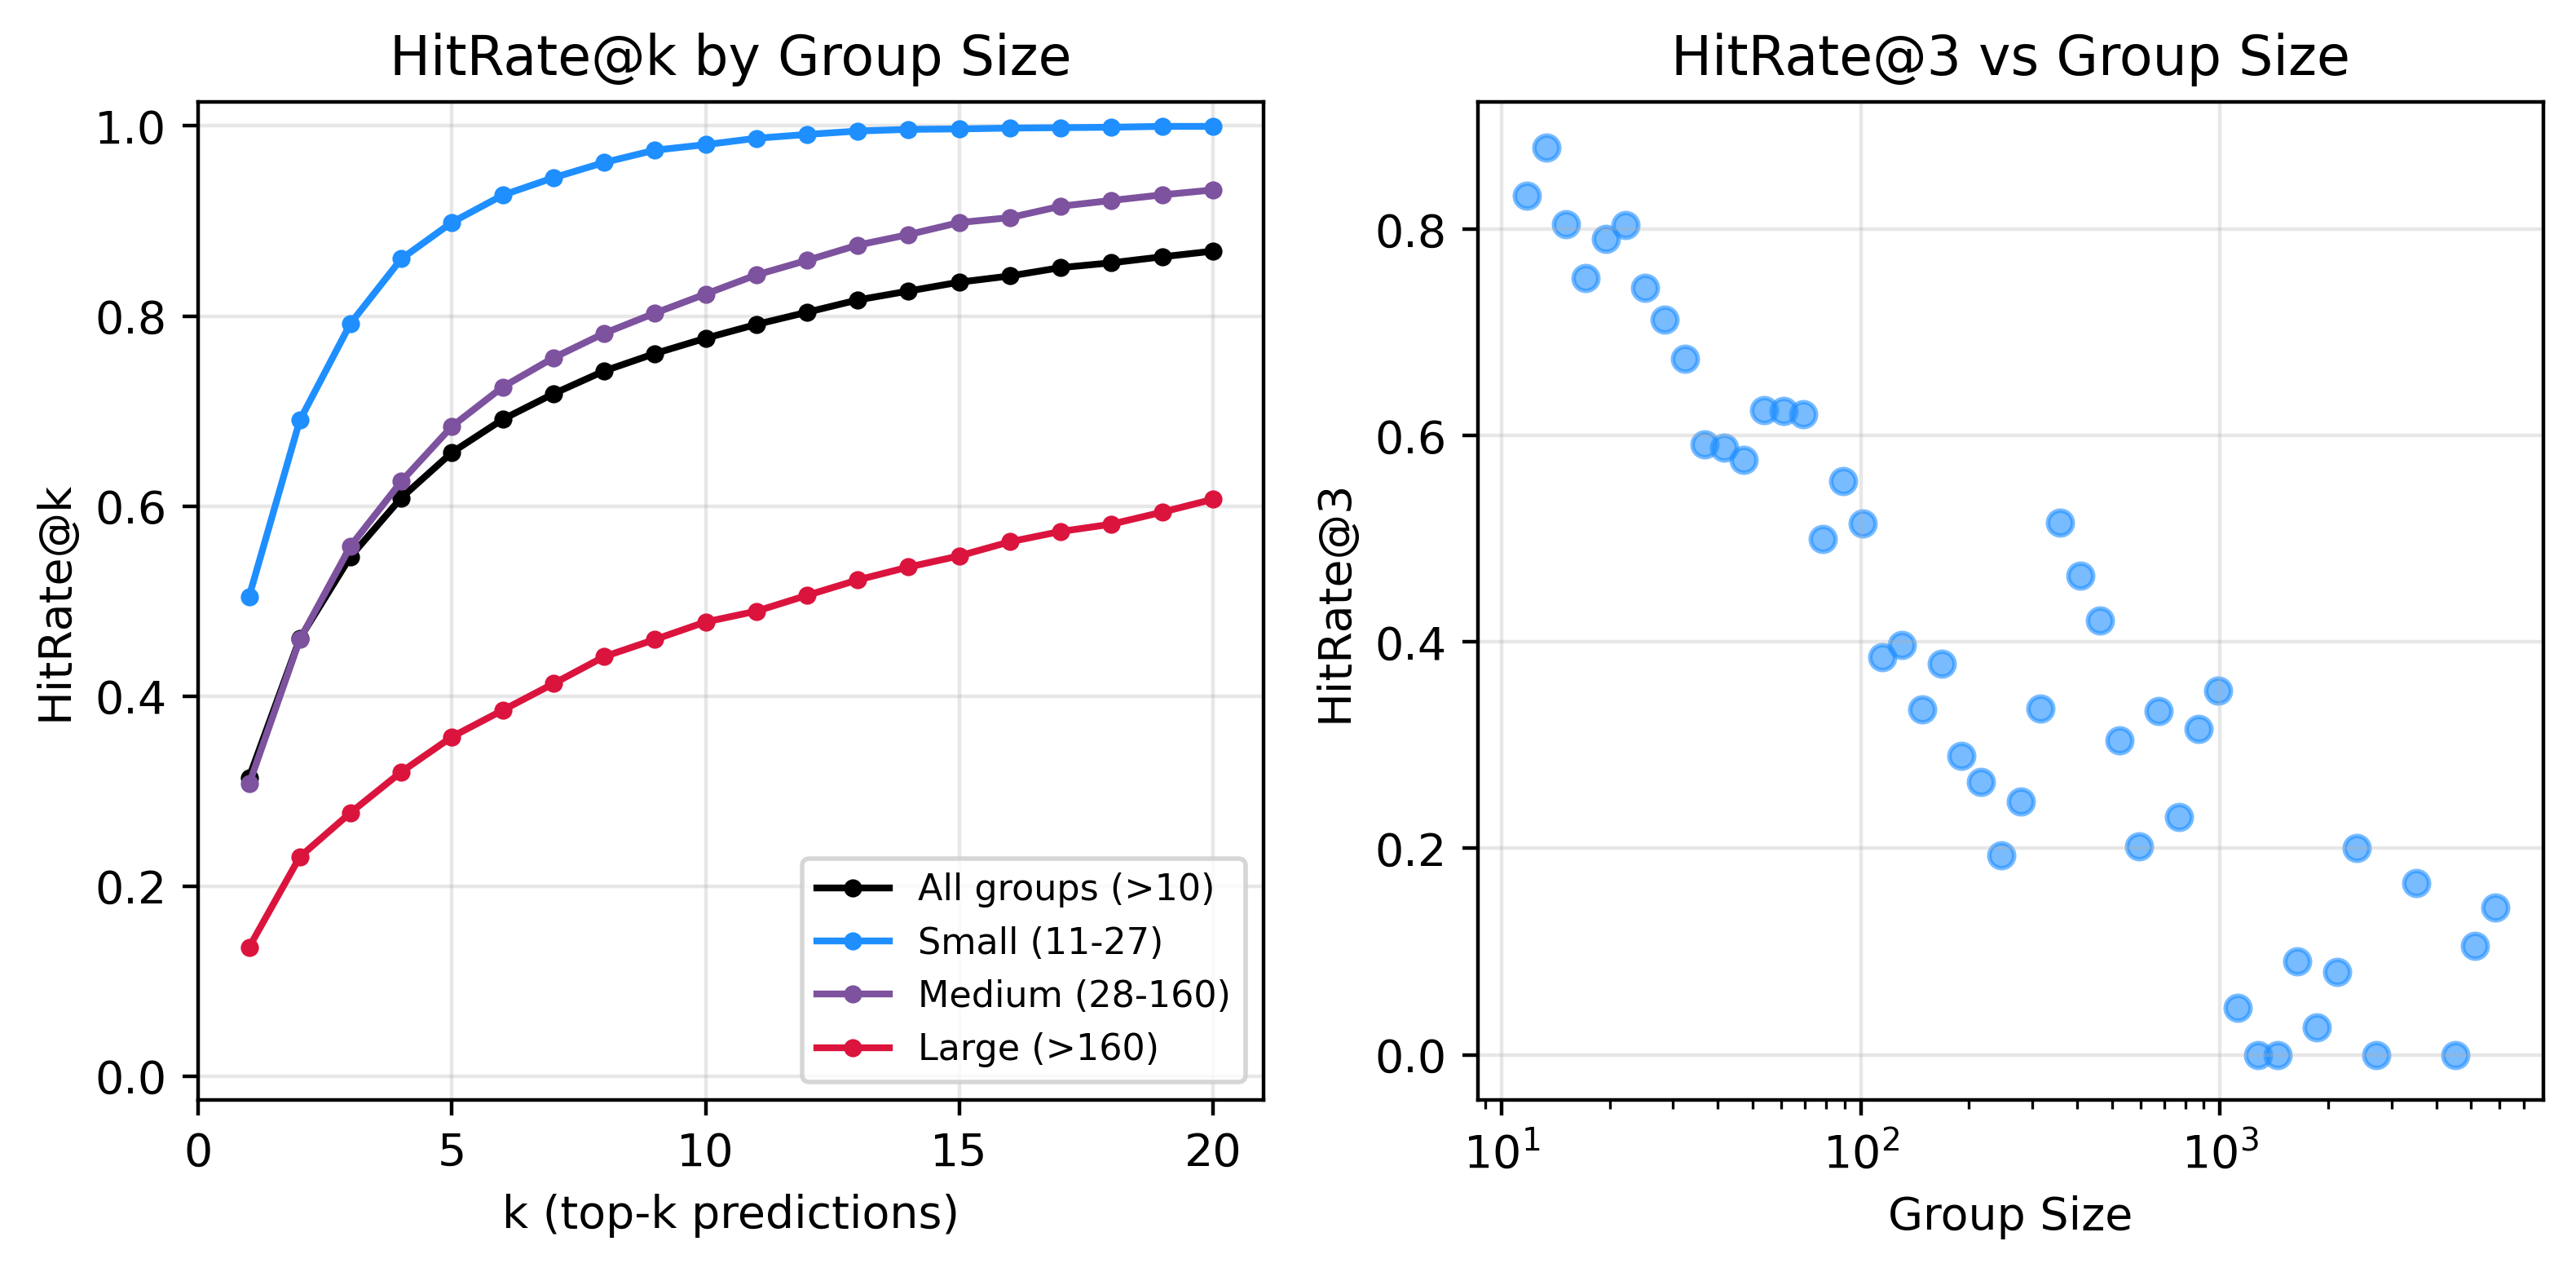

In [118]:
curves = plot_hitrate_at_k(groups_va, va_preds, y_va)

In [119]:
# Summary
print(f"HitRate@1: {curves['All groups (>10)'][0]:.5f}")
print(f"HitRate@3: {curves['All groups (>10)'][2]:.5f}")
print(f"HitRate@4: {curves['All groups (>10)'][3]:.5f}")
print(f"HitRate@5: {curves['All groups (>10)'][4]:.5f}")
print(f"HitRate@6: {curves['All groups (>10)'][5]:.5f}")
print(f"HitRate@10: {curves['All groups (>10)'][9]:.5f}")

HitRate@1: 0.31446
HitRate@3: 0.54695
HitRate@4: 0.60865
HitRate@5: 0.65650
HitRate@6: 0.69129
HitRate@10: 0.77663


## Submission

In [106]:
if FULL:
    submission_path = os.path.join(SUBMIT_DIR, f"submission_{TIME_TAG}.parquet")
    score_path = os.path.join(SUBMIT_DIR, "score", f"{TIME_TAG}.parquet")
    if MODEL == "xgboost":
        make_submission(test, dtest, model, submission_path, rerank=True)
        make_submission(test, dtest, model, score_path, True, True)
    elif MODEL == "lightgbm":
        make_submission(test, X_te, model, submission_path, rerank=True)
        make_submission(test, X_te, model, score_path, True, True)

In [107]:
# !kaggle competitions submit -c aeroclub-recsys-2025 -f {submission_file} -m {TIME_TAG}